In [11]:
import numpy as np
import os
import matplotlib.pyplot as plt

# shunqing

## Prediction

In [55]:
cwd = './results/shunqing/10s_res_norm_roll_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [56]:
event = 'bpswmm_61'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred


In [57]:
err.shape

(391, 10, 105, 6)

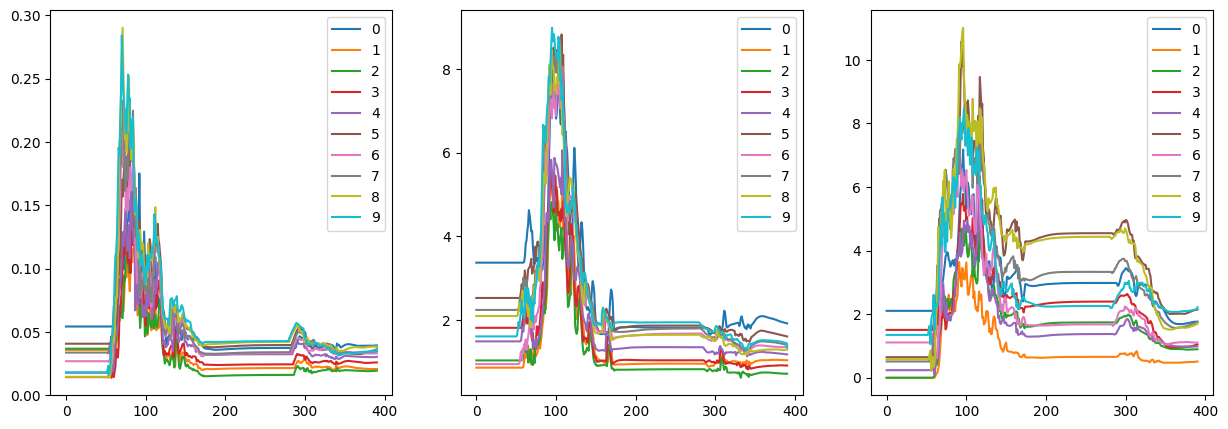

In [58]:
# true = np.load(os.path.join(cwd,event+'_true.npy'))
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0.5, 1.0, 'Flooding')

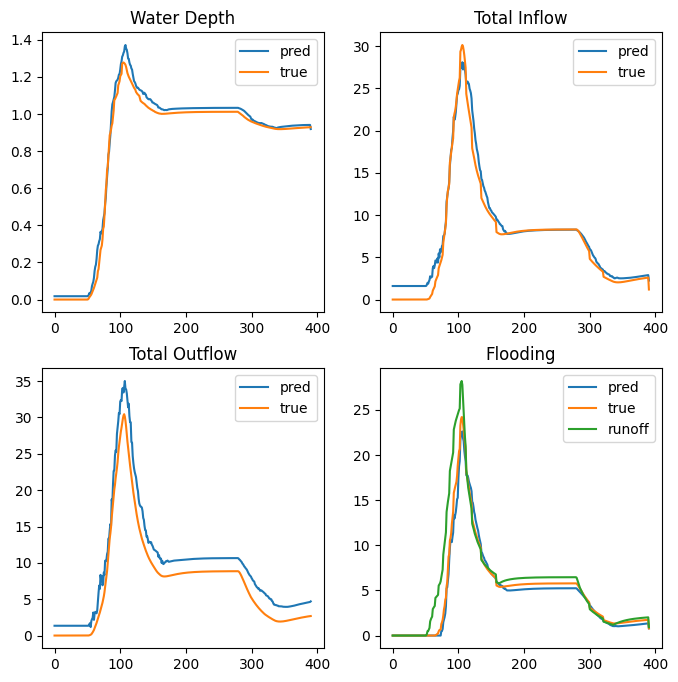

In [59]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='pred')
ax4.plot(true[:,seq,...].mean(axis=1)[:,-1],label='true')
ax4.plot(r[:,seq,...].mean(axis=1),label='runoff')
ax4.legend()
ax4.set_title('Flooding')

- Select a Node to plot, what is the outlet boundary?
- Cannot predict water level of a specific node precisely
    - Possibly because it depends on both up and downstream
    - Or it can be better if nodes have storage volumes: not significant
    - Water level error makes up with small loss: Normalization works
- Cannot Predict flooding precisely
    - Classify flooding or not: It works!!!

In [46]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')
nodes = [k for k in inp.JUNCTIONS]

Text(0.5, 1.0, 'Flooding')

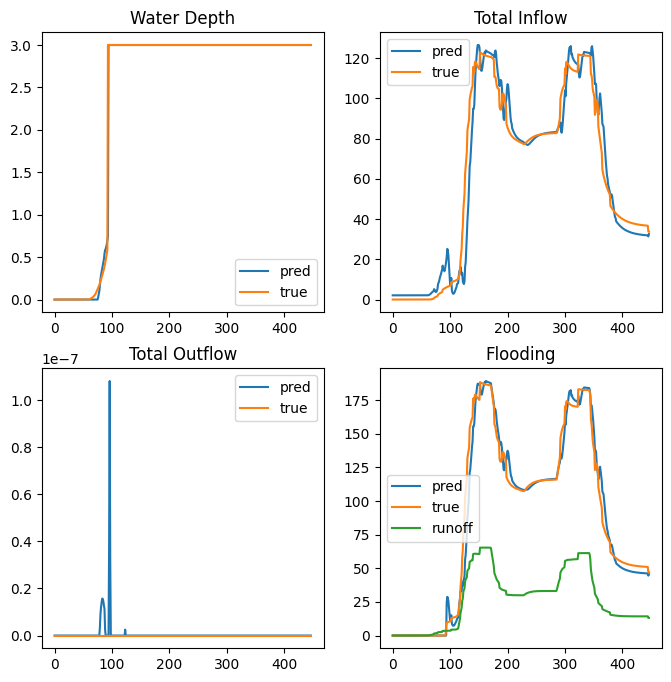

In [50]:
idx = nodes.index('jd35')
seq = 0

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,idx,-1],label='pred')
ax4.plot(true[:,seq,idx,-1],label='true')
ax4.plot(r[:,seq,idx,0],label='runoff')
ax4.legend()
ax4.set_title('Flooding')

Text(0.5, 1.0, 'flood prediction')

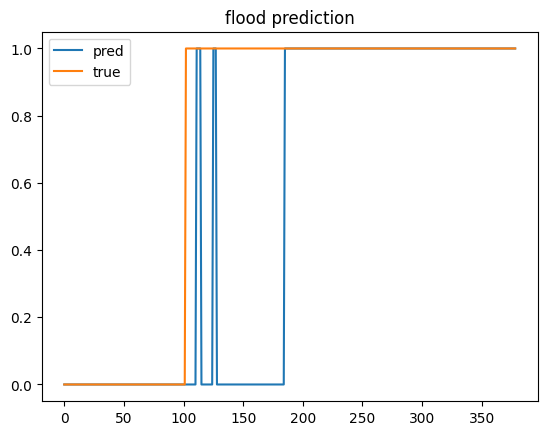

In [35]:
seq = 0

plt.plot(np.argmax(pred[:,seq,...].mean(axis=1)[:,-2:],axis=-1),label='pred')
plt.plot(np.argmax(true[:,seq,...].mean(axis=1)[:,-2:],axis=-1),label='true')
plt.legend()
plt.title('flood prediction')

In [ ]:
hmax = np.array([v.MaxDepth for _,v in inp.JUNCTIONS.items()])

Text(0.5, 1.0, 'flood prediction')

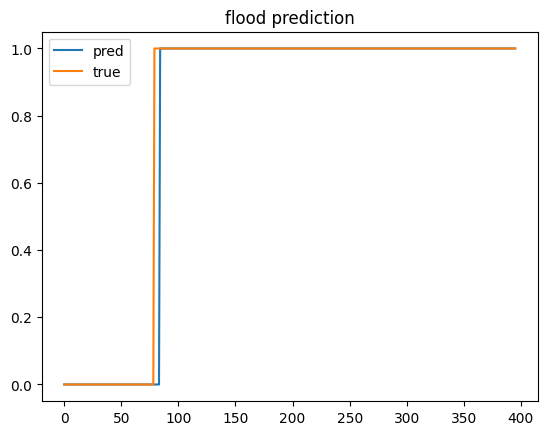

In [48]:
idx = nodes.index('jd28')
seq = -1

plt.plot(np.argmax(pred[:,seq,idx,-2:],axis=-1),label='pred')
plt.plot(np.argmax(true[:,seq,idx,-2:],axis=-1),label='true')
plt.legend()
plt.title('flood prediction')

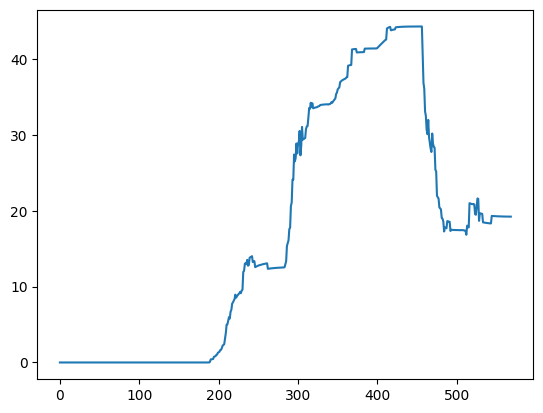

In [38]:
h,q_us,q_ds,q_w = [pred[...,i] for i in range(4)]
plt.plot(((q_us + r[...,0] - q_ds).clip(0) * ((hmax-h)<0.1))[:,0,:].mean(axis=1))

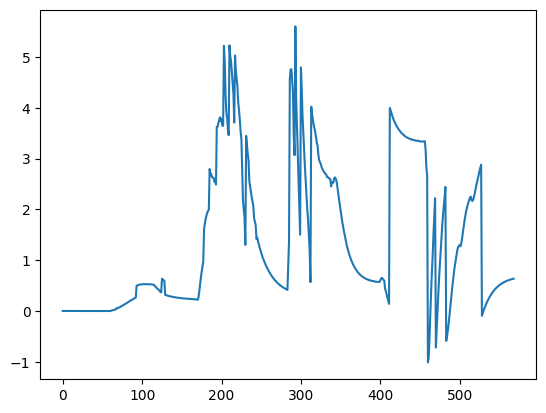

In [41]:
h,q_us,q_ds,q_w = [true[...,i] for i in range(4)]
plt.plot((q_us+r[...,-1]-q_ds-q_w)[:,0,:].mean(axis=1))

In [14]:
pred.shape

(569, 5, 105, 4)

In [17]:
hmax.shape

(105,)

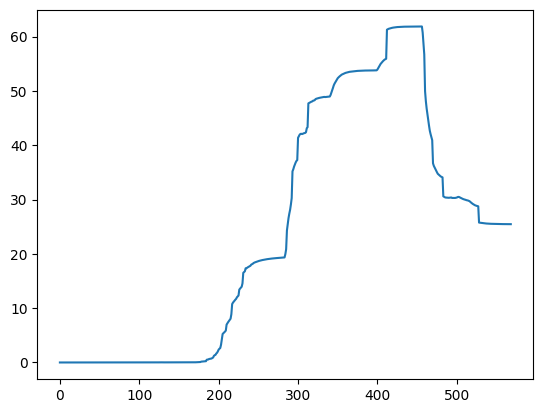

In [31]:
h,q_us,q_ds,q_w = [true[...,i] for i in range(4)]
plt.plot(((q_us + r[...,0] - q_ds).clip(0) * ((hmax-h)<0.01))[:,0,:].mean(axis=1))

## Train loss

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
cwd = './model/shunqing/10s_10k_res_norm_bal_flood/'
train_losses = np.load(os.path.join(cwd,'train_loss.npy'))
test_losses = np.load(os.path.join(cwd,'test_loss.npy'))
train_ids = np.load(os.path.join(cwd,'train_id.npy'))
test_ids = np.load(os.path.join(cwd,'test_id.npy'))

In [5]:
train_ids

array([108,  55,   3,  43, 146,  19, 125,   3, 135,  58,   1,  71,  26,
        78, 130,  76,  54, 111, 123, 121,  99, 135, 141, 130,   5, 124,
         6,  25,  50, 127,   6,   2, 104,  77,  86, 141, 116,  18,  13,
        76,  91,  12, 123, 130,  19,  64,  72,  96,  77,  67,   3,  68,
        29,   7, 122,  76, 127,  14,  11,  55,  46,  91,  20, 124,  89,
        31,   7,  23,  80,   6,  46,  20,  69, 137,  77, 100,   5,  37,
         7,  22,  96,  79, 108,  90,  97,  38, 130, 133,  33, 118,  88,
       101,  79,  48, 142, 122,  84,  38,  98,  66, 132,  74,  18,  87,
        33,  38,  33,  26,   0,  41,  95,  68,  69,  58, 119,  53,  81,
       121])

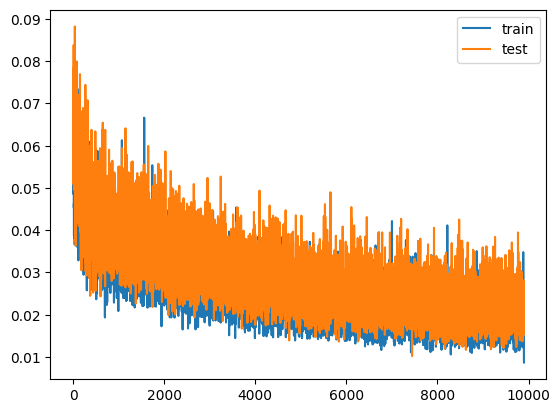

In [10]:
plt.plot(train_losses[100:],label='train')
plt.plot(test_losses[100:],label='test')
plt.legend()

# RedChicoSur

## Prediction

In [64]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [39]:
cwd = './results/RedChicoSur/5s_act_res_norm_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [40]:
event = 'train_0'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred


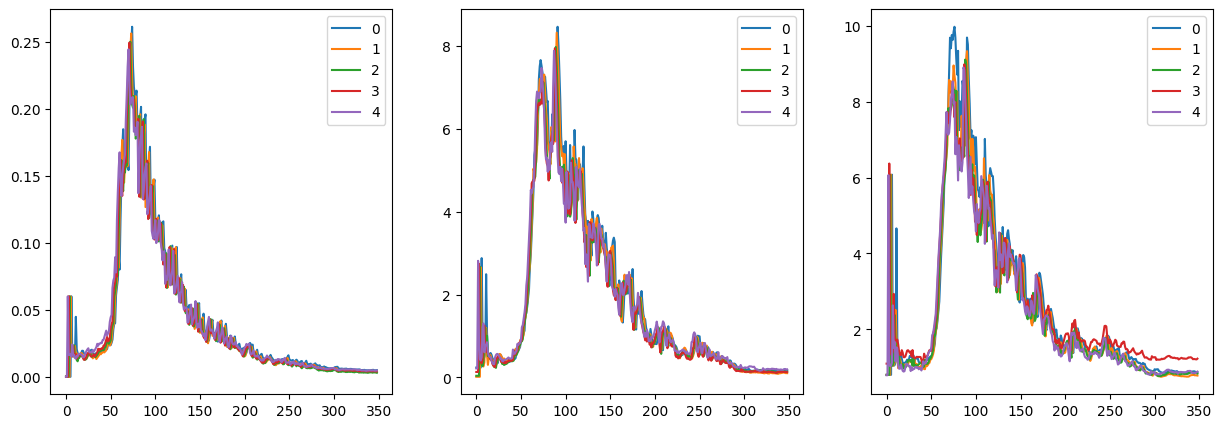

In [41]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0.5, 1.0, 'Flooding')

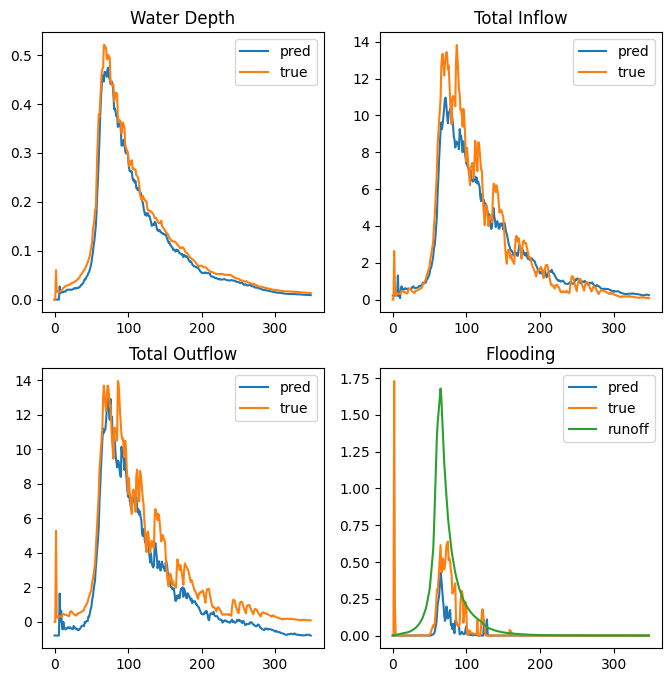

In [45]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='pred')
ax4.plot(true[:,seq,...].mean(axis=1)[:,-1],label='true')
ax4.plot(r[:,seq,...].mean(axis=1),label='runoff')
ax4.legend()
ax4.set_title('Flooding')

In [46]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/RedChicoSur/RedChicoSur.inp')
nodes = [k for k in inp.JUNCTIONS]

Text(0.5, 1.0, 'Flooding')

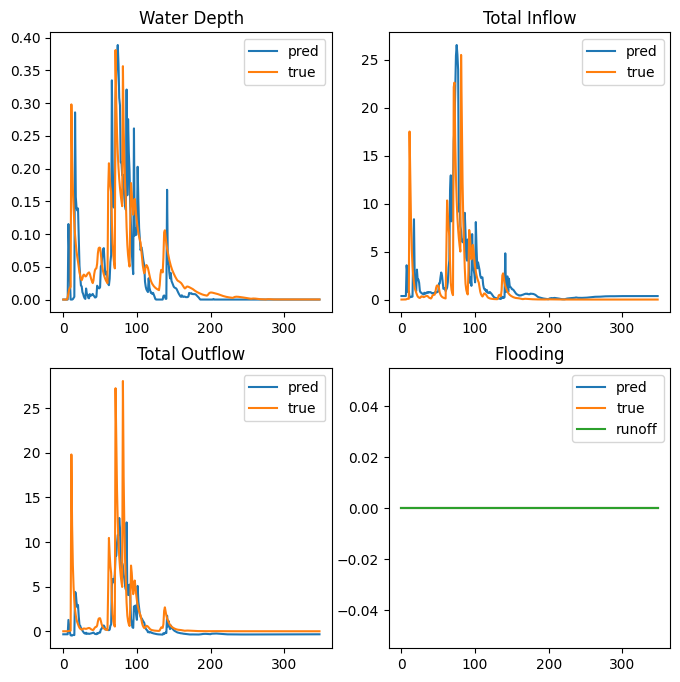

In [47]:
idx = nodes.index('PMP92989')
seq = -1

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,idx,-1],label='pred')
ax4.plot(true[:,seq,idx,-1],label='true')
ax4.plot(r[:,seq,idx,0],label='runoff')
ax4.legend()
ax4.set_title('Flooding')

## Training

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [62]:
cwd = './model/RedChicoSur/5s_10k_act_res_norm_flood/'
train_losses = np.load(os.path.join(cwd,'train_loss.npy'))
test_losses = np.load(os.path.join(cwd,'test_loss.npy'))
train_ids = np.load(os.path.join(cwd,'train_id.npy'))
test_ids = np.load(os.path.join(cwd,'test_id.npy'))

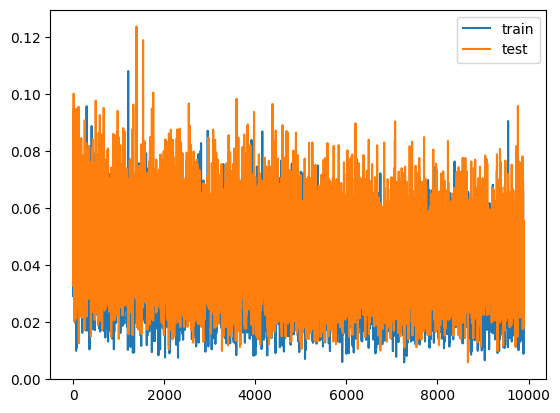

In [63]:
plt.plot(train_losses[100:],label='train')
plt.plot(test_losses[100:],label='test')
plt.legend()

# astlingen

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt

In [23]:
cwd = './results/astlingen/10s_act_res_norm_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [34]:
event = 'astlingen_08_21_2001_08'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred

In [112]:
true.shape

(542, 10, 29, 6)

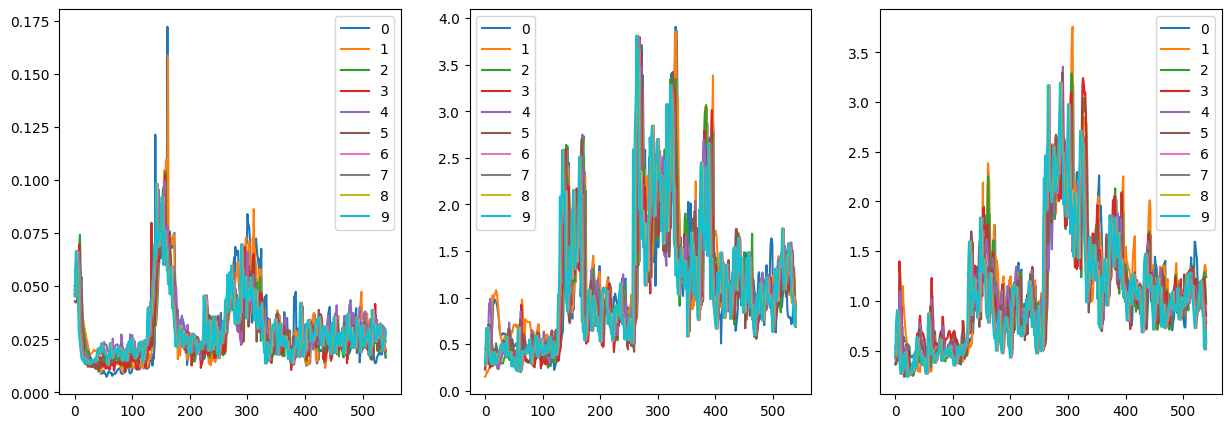

In [35]:
fig,axes = plt.subplots(1,3,figsize=(15,5))
for i,ax in enumerate(axes):
    for j in range(err.shape[1]):
        ax.plot(np.abs(err).mean(axis=2)[:,j,i],label=j)
    ax.legend()

Text(0.5, 1.0, 'Flooding')

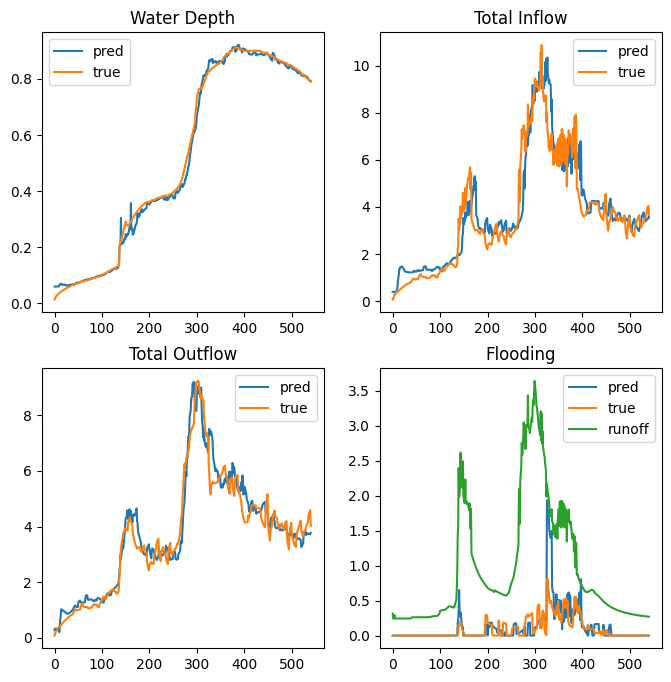

In [36]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = 0

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='pred')
ax4.plot(true[:,seq,...].mean(axis=1)[:,-1],label='true')
ax4.plot(r[:,seq,...].mean(axis=1),label='runoff')
ax4.legend()
ax4.set_title('Flooding')

In [27]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/astlingen/astlingen.inp')
nodes = [k for k in list(inp.JUNCTIONS)+list(inp.STORAGE)]

Text(0.5, 1.0, 'Flooding')

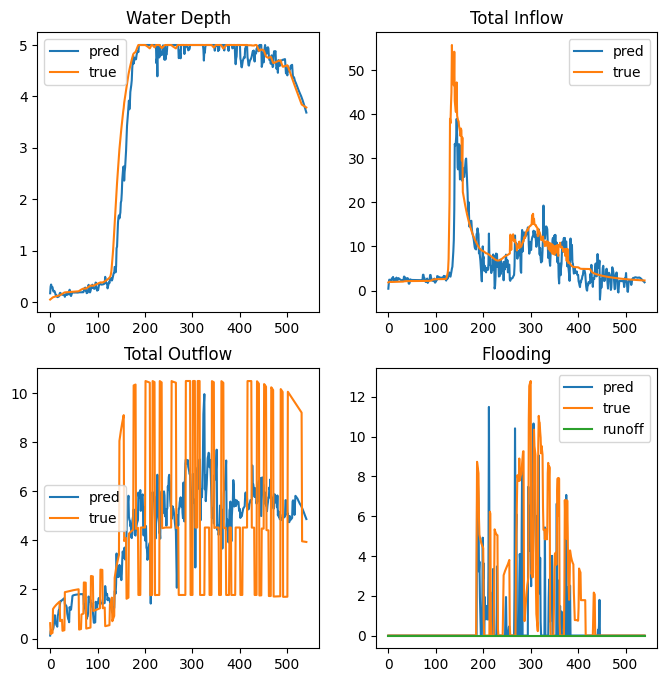

In [37]:
idx = nodes.index('T6')
seq = -1

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,idx,-1],label='pred')
ax4.plot(true[:,seq,idx,-1],label='true')
ax4.plot(r[:,seq,idx,0],label='runoff')
ax4.legend()
ax4.set_title('Flooding')